In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold = np.inf)

1.13.1
1.15.4


In [2]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

# Create data

## Create data generator

In [3]:
simple_data_genertator = False

percent_sequence_before_anomaly = 70.0
percent_sequence_after_anomaly = 0.0

def create_time_series_normal_parameters():
    normal_frequency_noise_scale = 1.0
    normal_frequence_noise_shift = 1.0

    normal_amplitude_noise_scale = 1.0
    normal_amplitude_noise_shift = 1.0

    normal_noise_noise_scale = 1.0

    if simple_data_genertator == True:
        normal_freq = 1.0
        normal_ampl = 1.0
    else:
        normal_freq = (np.random.random() * normal_frequency_noise_scale) + normal_frequence_noise_shift
        normal_ampl = np.random.random() * normal_amplitude_noise_scale + normal_amplitude_noise_shift
    
    return {"normal_freq": normal_freq, "normal_ampl": normal_ampl, "normal_noise_noise_scale": normal_noise_noise_scale}
  
def create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale):
    # Normal parameters
    if simple_data_genertator == True:
        sequence = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl for _ in range(number_of_sequences)], axis = 0)
    else:
        sequence = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl + [np.random.random() * normal_noise_noise_scale for i in range(sequence_length)] for _ in range(number_of_sequences)], axis = 0)

    return sequence

def create_time_series_with_anomaly(number_of_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, normal_freq, normal_ampl, normal_noise_noise_scale):
    sequence_length_before_anomaly = int(sequence_length * percent_sequence_before_anomaly / 100.0)
    sequence_length_after_anomaly = int(sequence_length * percent_sequence_after_anomaly / 100.0)
    sequence_length_anomaly = sequence_length - sequence_length_before_anomaly - sequence_length_after_anomaly

    # Anomalous parameters
    anomalous_amplitude_multipler_min = 8.0
    anomalous_amplitude_multipler_max = 20.0

    if simple_data_genertator == True:
        sequence_with_anomaly = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl for _ in range(number_of_sequences)], axis = 0)
    else:
        sequence_with_anomaly = create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale)
    sequence_with_anomaly[:, sequence_length_before_anomaly:sequence_length_before_anomaly + sequence_length_anomaly] *= ((anomalous_amplitude_multipler_max - anomalous_amplitude_multipler_min) * np.random.random_sample([number_of_sequences, sequence_length_anomaly]) + anomalous_amplitude_multipler_min) * (np.random.randint(2, size = [number_of_sequences, sequence_length_anomaly]) * -2 + 1)
    
    return sequence_with_anomaly

In [4]:
test_normal_parameters = create_time_series_normal_parameters()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


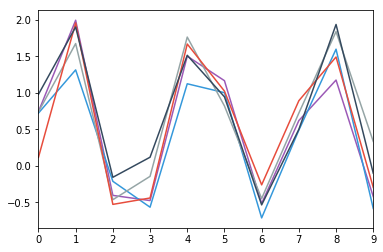

In [5]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
    sns.tsplot(create_time_series_normal(1, 10, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

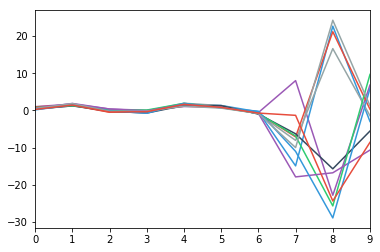

In [6]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 10):
    sns.tsplot(create_time_series_with_anomaly(1, 10, percent_sequence_before_anomaly, percent_sequence_after_anomaly, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

## Create training and evaluation data

In [7]:
number_of_training_normal_sequences = 6400

number_of_validation_normal_1_sequences = 640
number_of_validation_normal_2_sequences = 640
number_of_validation_anomalous_sequences = 640

number_of_test_normal_sequences = 640
number_of_test_anomalous_sequences = 640

sequence_length = 10
number_of_tags = 5
tag_columns = ["tag_{0}".format(tag) for tag in range(0, number_of_tags)]

In [8]:
tag_data_list = [create_time_series_normal_parameters() for tag in range(0, number_of_tags)]
tag_data_list

[{'normal_ampl': 1.233701210795159,
  'normal_freq': 1.9547823066735681,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.7404666320410689,
  'normal_freq': 1.8992017802994314,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.778501650144606,
  'normal_freq': 1.0860814805558063,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.0420962138354026,
  'normal_freq': 1.1490107665723808,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.4485046637192518,
  'normal_freq': 1.200153990154789,
  'normal_noise_noise_scale': 1.0}]

In [9]:
# Create training set using normal sequences
training_normal_sequences_list = [create_time_series_normal(number_of_training_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
training_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = training_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_training_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
np.random.shuffle(training_normal_sequences_array)
print("training_normal_sequences_array.shape = \n{}".format(training_normal_sequences_array.shape))

training_normal_sequences_array.shape = 
(6400, 5)


In [10]:
# Create validation sets
# Create set vn1 of normal sequences which will be used for early stopping during training as well as using the error vectors to learn mu and sigma for mahalanobis distance
validation_normal_1_sequences_list = [create_time_series_normal(number_of_validation_normal_1_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_1_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_1_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_1_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_1_sequences_array.shape = \n{}".format(validation_normal_1_sequences_array.shape))

# Create set vn2 of normal sequences which will be used for tuning the anomaly thresholds
validation_normal_2_sequences_list = [create_time_series_normal(number_of_validation_normal_2_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_2_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_2_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_2_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_2_sequences_array.shape = \n{}".format(validation_normal_2_sequences_array.shape))

# Create set va of anomalous sequences which will be used for tuning the anomaly thresholds
validation_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_validation_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_anomalous_sequences_array.shape = \n{}".format(validation_anomalous_sequences_array.shape))

validation_normal_1_sequences_array.shape = 
(640, 5)
validation_normal_2_sequences_array.shape = 
(640, 5)
validation_anomalous_sequences_array.shape = 
(640, 5)


In [11]:
# Create test sets
# Create set tn of normal sequences which will be used for testing model
test_normal_sequences_list = [create_time_series_normal(number_of_test_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_normal_sequences_array.shape = \n{}".format(test_normal_sequences_array.shape))

# Create set ta of anomalous sequences which will be used for testing model
test_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_test_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_anomalous_sequences_array.shape = \n{}".format(test_anomalous_sequences_array.shape))

test_normal_sequences_array.shape = 
(640, 5)
test_anomalous_sequences_array.shape = 
(640, 5)


In [12]:
# Combine vn2 and va sets for tuning anomaly thresholds
labeled_validation_normal_2_sequences_array = np.concatenate(seq = [validation_normal_2_sequences_array, np.zeros(shape = [validation_normal_2_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_anomalous_sequences_array = np.concatenate(seq = [validation_anomalous_sequences_array, np.ones(shape = [validation_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_mixed_sequences_array = np.concatenate(seq = [labeled_validation_normal_2_sequences_array, labeled_validation_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_validation_mixed_sequences_array)
print("labeled_validation_mixed_sequences_array.shape = \n{}".format(labeled_validation_mixed_sequences_array.shape))

# Combine tn and ta sets for testing model
labeled_test_normal_sequences_array = np.concatenate(seq = [test_normal_sequences_array, np.zeros(shape = [test_normal_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labled_test_anomalous_sequences_array = np.concatenate(seq = [test_anomalous_sequences_array, np.ones(shape = [test_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_test_mixed_sequences_array = np.concatenate(seq = [labeled_test_normal_sequences_array, labled_test_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_test_mixed_sequences_array)
print("labeled_test_mixed_sequences_array.shape = \n{}".format(labeled_test_mixed_sequences_array.shape))

labeled_validation_mixed_sequences_array.shape = 
(1280, 6)
labeled_test_mixed_sequences_array.shape = 
(1280, 6)


In [13]:
np.savetxt(fname = "data/training_normal_sequences.csv", X = training_normal_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/validation_normal_1_sequences.csv", X = validation_normal_1_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/labeled_validation_mixed_sequences.csv", X = labeled_validation_mixed_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/labeled_test_mixed_sequences.csv", X = labeled_test_mixed_sequences_array, fmt = '%s', delimiter = ";")

In [14]:
!head -3 data/training_normal_sequences.csv

0.66606433,1.39219185,-0.70602441,-0.41544721,1.3366158,0.39513613,-0.81612433,1.26341258,0.4318331,-0.45333239;0.96767403,2.54916633,-0.54625043,-0.79575956,2.5440888,0.6303442,-0.77558924,1.29662855,1.12009182,-1.44183853;0.47633211,1.77061958,1.80649529,-0.178733,-1.37228868,-1.14108605,1.00014748,2.17013658,1.30258531,-0.10681501;0.76046545,1.16996358,1.26509615,0.55914014,-0.16828103,-0.23416779,1.44688558,1.29667854,0.67662976,-0.80561563;0.49196738,2.26062599,1.58686973,0.32738362,-1.22997975,-0.08200596,1.43765989,1.52245814,-0.17299406,-1.39229234
5.33277033e-01,2.01387936e+00,-4.13562154e-01,1.23200330e-01,1.27304077e+00,-1.98395848e-03,-7.25909446e-01,1.77092680e+00,9.44655521e-01,-5.84914701e-01;0.07809947,2.35287642,-0.43008166,-0.9437877,2.45195335,0.41335562,-0.74129839,2.14417088,0.95233385,-1.38103345;0.46615715,2.43050969,1.50950435,0.65564711,-1.1672063,-0.94463763,1.35947452,2.23275268,1.52455308,-0.44912703;0.04600421,1.02669441,0.83335434,0.35100966,-0.24355617,-0

In [15]:
!head -3 data/validation_normal_1_sequences.csv

0.19137783,1.87615478,-0.53987886,-0.11104339,1.90501873,-0.30905665,-0.19640263,1.68749551,0.08902822,-0.87749856;0.18738323,1.96900908,-0.17950189,-0.55254592,2.3187406,0.48645066,-0.81364207,2.06792628,1.06592352,-1.16915957;0.13792195,1.97193719,2.01091169,0.34326042,-1.102581,-0.65095263,0.90436066,1.73666151,1.61499703,-0.07663687;0.09815869,1.11032722,0.96646269,0.52094349,-0.52363182,0.23094867,1.2237676,1.33641733,0.46458539,-0.15347957;0.99937256,1.79197032,1.57249241,0.13073308,-0.62372704,0.25202159,1.68731505,1.29791125,-0.02412073,-0.4236964
0.41717319,1.19210854,-0.25292773,-0.42596813,1.9629642,-0.12443989,-0.15186408,1.14772947,1.0252742,-1.01286604;0.48571965,2.1807864,-0.1926819,-0.07123492,2.19893334,0.46134548,-0.83543573,1.46364533,1.7610167,-1.07108481;0.48441314,1.61045801,1.8638236,0.67258534,-1.23393104,-0.88310189,0.53996276,2.43692401,1.64447235,-0.47838054;0.19611007,0.96223803,1.27213832,0.42460726,-0.77163816,-0.16620915,0.99340416,1.85663775,1.04193044,-

In [16]:
!head -3 data/labeled_validation_mixed_sequences.csv

0.5269803,1.25340534,0.03217257,-0.22498655,1.51997742,0.2521967,-0.80691329,1.86006035,0.16698989,-0.45723342;0.69807978,1.90814152,-0.84788395,-0.23218853,2.64659935,0.36960284,-1.49632727,1.75147203,1.35825343,-1.05009047;0.78253986,1.77152785,1.56377743,0.33452063,-1.43251473,-1.28895425,0.80592563,2.56508627,1.91744622,-0.48313508;0.56895425,1.79072792,1.30855016,0.0132353,-0.57917565,-0.00348695,1.32978551,1.64852634,0.70754291,-0.33744032;0.01751579,1.46469063,1.87023154,0.02809033,-1.26886366,0.55905798,1.60574389,1.50486718,0.38367057,-1.00001172;0
0.58053946,1.68053727,-0.20768729,0.24691785,1.67564006,-0.34614648,-0.62210618,-21.05034842,4.22624079,19.56102319;0.08673369,2.07658371,-0.4282488,-0.76079113,2.33939663,0.04337955,-1.13639334,-26.55986259,-30.33336988,-7.30287913;0.88118571,1.93217196,1.84898973,0.31337769,-1.04936009,-1.14012844,0.98278194,-39.82769472,-33.65948107,2.26585581;0.90277737,1.32744348,1.46813664,0.08016658,-0.94773355,-0.09314811,0.69240536,9.857889

In [17]:
!head -3 data/labeled_test_mixed_sequences.csv

0.0297759,1.22188313,-0.7007994,-0.16291996,1.64295594,0.30962343,-0.8897269,1.44827242,0.9377256,-0.90067837;0.05478137,1.77067503,-0.09061404,-0.7321785,2.20370057,0.46654946,-0.85510445,1.77905972,1.60977712,-0.91393733;0.38546577,2.14006194,1.52944724,-0.10612647,-1.35911626,-1.15812466,1.29582662,2.19614424,1.46424099,-0.06337075;0.83093625,0.99201361,0.99730212,0.53876421,-0.08992922,0.44768994,1.42987097,1.73200728,0.82439843,-0.679102;0.66675759,1.93072346,1.78826107,0.12876835,-0.88484037,-0.3886429,1.31659696,1.34606258,-0.12322511,-0.85171911;0
0.06794892,1.79930225,-0.65522031,0.22778637,1.80694848,0.30079108,-0.60570394,1.94072472,0.6155229,-0.18080481;0.76655374,1.88799294,-0.15656883,-0.41324191,1.74989524,0.01249191,-0.60816255,1.3337263,1.06207503,-0.7605812;0.00651164,2.29683622,2.43377906,0.11538661,-0.75572253,-0.55662087,0.5750558,2.14211684,2.06562186,-0.36218684;0.1391152,1.56774377,1.02792517,0.46930885,-0.60505971,-0.21710788,1.33992631,1.43287756,0.47500969,-0

# Local Development

In [18]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)

In [19]:
# Determine CSV and label columns
UNLABELED_CSV_COLUMNS = tag_columns

LABEL_COLUMN = "anomalous_sequence_flag"
LABELED_CSV_COLUMNS = UNLABELED_CSV_COLUMNS + [LABEL_COLUMN]

# Set default values for each CSV column
UNLABELED_DEFAULTS = [[""] for _ in UNLABELED_CSV_COLUMNS]

LABELED_DEFAULTS = UNLABELED_DEFAULTS + [[0.0]]

In [20]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size, params):
    def _input_fn():
        def decode_csv(value_column, sequence_length):
            def convert_sequences_from_strings_to_floats(features, column_list):
                def split_and_convert_string(string_tensor):
                    # Split string tensor into a sparse tensor based on delimiter
                    split_string = tf.string_split(source = tf.expand_dims(input = string_tensor, axis = 0), delimiter = ",")

                    # Converts the values of the sparse tensor to floats
                    converted_tensor = tf.string_to_number(split_string.values, out_type = tf.float64)

                    # Create a new sparse tensor with the new converted values, because the original sparse tensor values are immutable
                    new_sparse_tensor = tf.SparseTensor(indices = split_string.indices, values = converted_tensor, dense_shape = split_string.dense_shape)

                    # Create a dense tensor of the float values that were converted from text csv
                    dense_floats = tf.sparse_tensor_to_dense(sp_input = new_sparse_tensor, default_value = 0.0)

                    dense_floats_vector = tf.squeeze(input = dense_floats, axis = 0)

                    return dense_floats_vector
                    
                for column in column_list:
                    features[column] = split_and_convert_string(features[column])
                    features[column].set_shape([sequence_length])


                return features
                
            columns = tf.decode_csv(records = value_column, record_defaults = UNLABELED_DEFAULTS, field_delim = ";")
            features = dict(zip(UNLABELED_CSV_COLUMNS, columns))
            features = convert_sequences_from_strings_to_floats(features, UNLABELED_CSV_COLUMNS)
            return features
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename = filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames = file_list)    # Read text file

        # Decode the CSV file into a features dictionary of tensors
        dataset = dataset.map(map_func = lambda x: decode_csv(x, params["sequence_length"]))
        
        # Group the data into batches
        dataset = dataset.batch(batch_size = batch_size)
        
        # Create a iterator and then pull the next batch of features from the example queue
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn

In [21]:
def try_out_input_function():
    with tf.Session() as sess:
        fn = read_dataset(
          filename = "data/labeled_validation_mixed_sequences.csv",
          mode = tf.estimator.ModeKeys.EVAL,
          batch_size = 8,
          params = {"sequence_length": sequence_length,
                    "evaluation_mode": "tune_anomaly_thresholds"})

        features = sess.run(fn())
        print("try_out_input_function: features = \n{}".format(features))

#         print("try_out_input_function: features[tag_0].shape = {}".format(features["tag_0"].shape))

In [22]:
# try_out_input_function()

In [23]:
# Create our model function to be used in our custom estimator
def pca_anomaly_detection(features, labels, mode, params):
    print("\npca_anomaly_detection: features = \n{}".format(features))
    print("pca_anomaly_detection: labels = \n{}".format(labels))
    print("pca_anomaly_detection: mode = \n{}".format(mode))
    print("pca_anomaly_detection: params = \n{}".format(params))

    # 0. Get input sequence tensor into correct shape
    # Get dynamic batch size in case there was a partially filled batch
    current_batch_size = tf.shape(input = features[UNLABELED_CSV_COLUMNS[0]], out_type = tf.int64)[0]

    # Get the number of features 
    number_of_features = len(UNLABELED_CSV_COLUMNS)

    # Stack all of the features into a 3-D tensor
    X = tf.stack(values = list(features.values()), axis = 2) # shape = (current_batch_size, sequence_length, number_of_features)

    # Reshape into a 2-D tensors
    # Time based
    X_time = tf.reshape(tensor = X, shape = [current_batch_size * params["sequence_length"], number_of_features]) # shape = (current_batch_size * sequence_length, number_of_features)
    
    # Features based
    X_transposed = tf.transpose(a = X, perm = [0, 2, 1]) # shape = (current_batch_size, number_of_features, sequence_length)
    X_features = tf.reshape(tensor = X_transposed, shape = [current_batch_size * number_of_features, params["sequence_length"]]) # shape = (current_batch_size * number_of_features, sequence_length)

    ################################################################################
  
    # Variables for calculating error distribution statistics
    with tf.variable_scope(name_or_scope = "pca_variables", reuse = tf.AUTO_REUSE):
        # Time based
        pca_time_count_variable = tf.get_variable(name = "pca_time_count_variable", # shape = ()
                                                  dtype = tf.int64,
                                                  initializer = tf.zeros(shape = [], 
                                                                         dtype = tf.int64),
                                                  trainable = False)
        
        pca_time_mean_variable = tf.get_variable(name = "pca_time_mean_variable", # shape = (number_of_features,)
                                                 dtype = tf.float64,
                                                 initializer = tf.zeros(shape = [number_of_features], 
                                                                        dtype = tf.float64),
                                                 trainable = False)
        
        pca_time_covariance_matrix_variable = tf.get_variable(name = "pca_time_covariance_matrix_variable", # shape = (number_of_features, number_of_features)
                                                              dtype = tf.float64,
                                                              initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                     dtype = tf.float64),
                                                              trainable = False)

        pca_time_eigenvalues_variable = tf.get_variable(name = "pca_time_eigenvalues_variable", # shape = (number_of_features,)
                                                        dtype = tf.float64,
                                                        initializer = tf.zeros(shape = [number_of_features], 
                                                                               dtype = tf.float64),
                                                        trainable = False)
        
        pca_time_eigenvectors_variable = tf.get_variable(name = "pca_time_eigenvectors_variable", # shape = (number_of_features, number_of_features)
                                                         dtype = tf.float64,
                                                         initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                dtype = tf.float64),
                                                         trainable = False)
        
        
        # Features based
        pca_features_count_variable = tf.get_variable(name = "pca_features_count_variable", # shape = ()
                                                      dtype = tf.int64,
                                                      initializer = tf.zeros(shape = [], 
                                                                             dtype = tf.int64),
                                                      trainable = False)
        
        pca_features_mean_variable = tf.get_variable(name = "pca_features_mean_variable", # shape = (sequence_length,)
                                                     dtype = tf.float64,
                                                     initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                            dtype = tf.float64),
                                                     trainable = False)
        
        pca_features_covariance_matrix_variable = tf.get_variable(name = "pca_features_covariance_matrix_variable", # shape = (sequence_length, sequence_length)
                                                                  dtype = tf.float64,
                                                                  initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                         dtype = tf.float64),
                                                                  trainable = False)

        pca_features_eigenvalues_variable = tf.get_variable(name = "pca_features_eigenvalues_variable", # shape = (sequence_length,)
                                                            dtype = tf.float64,
                                                            initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                                   dtype = tf.float64),
                                                            trainable = False)
        
        pca_features_eigenvectors_variable = tf.get_variable(name = "pca_features_eigenvectors_variable", # shape = (sequence_length, sequence_length)
                                                             dtype = tf.float64,
                                                             initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                    dtype = tf.float64),
                                                             trainable = False)

    dummy_variable = tf.get_variable(name = "dummy_variable", # shape = ()
                                     dtype = tf.float64,
                                     initializer = tf.zeros(shape = [], dtype = tf.float64),
                                     trainable = True)
    
    # Now branch off based on which mode we are in
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None
    
    # 3. Loss function, training/eval ops
    if mode == tf.estimator.ModeKeys.TRAIN:
        with tf.variable_scope(name_or_scope = "pca_variables", reuse = tf.AUTO_REUSE):
            # This function updates the count of records used
            def update_count(count_a, count_b):
                return count_a + count_b

            # This function updates the mahalanobis distance variables when the number_of_rows equals 1
            def singleton_batch_pca_variable_updating(inner_size, reshaped, pca_count_variable, pca_mean_variable, pca_covariance_matrix_variable):
                # This function updates the mean vector incrementally
                def update_mean_incremental(count_a, mean_a, value_b):
                    return (mean_a * tf.cast(x = count_a, dtype = tf.float64) + tf.squeeze(input = value_b, axis = 0)) / tf.cast(x = count_a + 1, dtype = tf.float64)

                # This function updates the covariance matrix incrementally
                def update_covariance_incremental(count_a, mean_a, cov_a, value_b, mean_ab, sample_covariance):
                    if sample_covariance == True:
                        cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) / tf.cast(x = count_a, dtype = tf.float64)
                    else:
                        cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) / tf.cast(x = count_a + 1, dtype = tf.float64)
                    return cov_ab

                # Calculate new combined mean to use for incremental covariance matrix calculation
                mean_ab = update_mean_incremental(count_a = pca_count_variable, 
                                                  mean_a = pca_mean_variable, 
                                                  value_b = reshaped) # time_shape = (number_of_features,), features_shape = (sequence_length,)

                # Update running variables from single example
                count_tensor = update_count(count_a = pca_count_variable, count_b = 1) # time_shape = (), features_shape = ()

                mean_tensor = mean_ab # time_shape = (number_of_features,), features_shape = (sequence_length,)

                if inner_size == 1:
                    covariance_matrix_tensor = tf.zeros_like(tensor = pca_covariance_matrix_variable, dtype = tf.float64)
                else:
                    covariance_matrix_tensor = update_covariance_incremental(count_a = pca_count_variable, 
                                                                             mean_a = pca_mean_variable, 
                                                                             cov_a = pca_covariance_matrix_variable, 
                                                                             value_b = reshaped, 
                                                                             mean_ab = mean_ab, 
                                                                             sample_covariance = True) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

                # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
                with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_covariance_matrix_variable, value = covariance_matrix_tensor)]):
                    with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_mean_variable, value = mean_tensor)]):
                        with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_count_variable, value = count_tensor)]):
                            return tf.identity(input = pca_covariance_matrix_variable), tf.identity(input = pca_mean_variable), tf.identity(input = pca_count_variable)

            # This function updates the mahalanobis distance variables when the number_of_rows does NOT equal 1
            def non_singleton_batch_pca_variable_updating(current_batch_size, inner_size, reshaped, pca_count_variable, pca_mean_variable, pca_covariance_matrix_variable):
                # This function updates the mean vector using a batch of data
                def update_mean_batch(count_a, mean_a, count_b, mean_b):
                    return (mean_a * tf.cast(x = count_a, dtype = tf.float64) + mean_b * tf.cast(x = count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)

                # This function updates the covariance matrix using a batch of data
                def update_covariance_batch(count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_covariance):
                    mean_diff = tf.expand_dims(input = mean_a - mean_b, axis = 0)

                    if sample_covariance == True:
                        cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + cov_b * tf.cast(x = count_b - 1, dtype = tf.float64) + tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b - 1, dtype = tf.float64)
                    else:
                        cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + cov_b * tf.cast(x = count_b, dtype = tf.float64) + tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)
                    return cov_ab                    

                # Find statistics of batch
                number_of_rows = current_batch_size * inner_size

                reshaped_mean = tf.reduce_mean(input_tensor = reshaped, axis = 0) # time_shape = (number_of_features,), features_shape = (sequence_length,)

                reshaped_centered = reshaped - reshaped_mean # time_shape = (current_batch_size * sequence_length, number_of_features), features_shape = (current_batch_size * number_of_features, sequence_length)

                if inner_size > 1:
                    reshaped_covariance_matrix = tf.matmul(a = reshaped_centered, # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)
                                                           b = reshaped_centered, 
                                                           transpose_a = True) / tf.cast(x = number_of_rows - 1, dtype = tf.float64)

                # Update running variables from batch statistics
                count_tensor = update_count(count_a = pca_count_variable, count_b = number_of_rows) # time_shape = (), features_shape = ()

                mean_tensor = update_mean_batch(count_a = pca_count_variable, 
                                                mean_a = pca_mean_variable, 
                                                count_b = number_of_rows, 
                                                mean_b = reshaped_mean) # time_shape = (number_of_features,), features_shape = (sequence_length,)

                if inner_size == 1:
                    covariance_matrix_tensor = tf.zeros_like(tensor = pca_covariance_matrix_variable, dtype = tf.float64)
                else:
                    covariance_matrix_tensor = update_covariance_batch(count_a = pca_count_variable, 
                                                                       mean_a = pca_mean_variable, 
                                                                       cov_a = pca_covariance_matrix_variable, 
                                                                       count_b = number_of_rows, 
                                                                       mean_b = reshaped_mean, 
                                                                       cov_b = reshaped_covariance_matrix, 
                                                                       sample_covariance = True) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

                # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
                with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_covariance_matrix_variable, value = covariance_matrix_tensor)]):
                    with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_mean_variable, value = mean_tensor)]):
                        with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_count_variable, value = count_tensor)]):
                            return tf.identity(input = pca_covariance_matrix_variable), tf.identity(input = pca_mean_variable), tf.identity(input = pca_count_variable)

            # Check if batch is a singleton or not, very important for covariance math

            # Time based ########################################
            singleton_condition = tf.equal(x = current_batch_size * params["sequence_length"], y = 1) # shape = ()

            pca_time_covariance_matrix_variable, pca_time_mean_variable, pca_time_count_variable = \
                tf.cond(pred = singleton_condition, 
                        true_fn = lambda: singleton_batch_pca_variable_updating(params["sequence_length"], X_time, pca_time_count_variable, pca_time_mean_variable, pca_time_covariance_matrix_variable), 
                        false_fn = lambda: non_singleton_batch_pca_variable_updating(current_batch_size, params["sequence_length"], X_time, pca_time_count_variable, pca_time_mean_variable, pca_time_covariance_matrix_variable))
            
            pca_time_eigenvalues_tensor, pca_time_eigenvectors_tensor = tf.linalg.eigh(tensor = pca_time_covariance_matrix_variable) # shape = (number_of_features,) & (number_of_features, number_of_features)

            # Features based ########################################
            singleton_batch_features_condition = tf.equal(x = current_batch_size * number_of_features, y = 1) # shape = ()

            pca_features_covariance_matrix_variable, pca_features_mean_variable, pca_features_count_variable = \
                tf.cond(pred = singleton_batch_features_condition, 
                        true_fn = lambda: singleton_batch_pca_variable_updating(number_of_features, X_features, pca_features_count_variable, pca_features_mean_variable, pca_features_covariance_matrix_variable), 
                        false_fn = lambda: non_singleton_batch_pca_variable_updating(current_batch_size, number_of_features, X_features, pca_features_count_variable, pca_features_mean_variable, pca_features_covariance_matrix_variable))
            
            pca_features_eigenvalues_tensor, pca_features_eigenvectors_tensor = tf.linalg.eigh(tensor = pca_features_covariance_matrix_variable) # shape = (sequence_length,) & (sequence_length, sequence_length)

        # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
        with tf.control_dependencies(control_inputs = [pca_time_covariance_matrix_variable, pca_features_covariance_matrix_variable]):
            with tf.control_dependencies(control_inputs = [pca_time_mean_variable, pca_features_mean_variable]):
                with tf.control_dependencies(control_inputs = [pca_time_count_variable, pca_features_count_variable]):
                    with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_time_eigenvalues_variable, value = pca_time_eigenvalues_tensor), 
                                                                   tf.assign(ref = pca_time_eigenvectors_variable, value = pca_time_eigenvectors_tensor),
                                                                   tf.assign(ref = pca_features_eigenvalues_variable, value = pca_features_eigenvalues_tensor), 
                                                                   tf.assign(ref = pca_features_eigenvectors_variable, value = pca_features_eigenvectors_tensor)]):
                        loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                        train_op = tf.contrib.layers.optimize_loss(
                            loss = loss,
                            global_step = tf.train.get_global_step(),
                            learning_rate = params["learning_rate"],
                            optimizer = "SGD")
    else:
        # Time based
        X_time_centered = X_time - pca_time_mean_variable # shape = (current_batch_size * sequence_length, number_of_features)
        X_time_projected = tf.matmul(a = X_time_centered, b = pca_time_eigenvectors_variable[:, -params["k_principal_components"]:]) # shape = (current_batch_size * sequence_length, params["k_principal_components"])
        X_time_reconstruction_error = X_time_centered - tf.matmul(a = X_time_projected, b = pca_time_eigenvectors_variable[:, -params["k_principal_components"]:], transpose_b = True) # shape = (current_batch_size * sequence_length, number_of_features)
        
        # Features based
        X_features_centered = X_features - pca_features_mean_variable # shape = (current_batch_size * number_of_features, sequence_length)
        X_features_projected = tf.matmul(a = X_features_centered, b = pca_features_eigenvectors_variable[:, -params["k_principal_components"]:]) # shape = (current_batch_size * number_of_features, params["k_principal_components"])
        X_features_reconstruction_error = X_features_centered - tf.matmul(a = X_features_projected, b = pca_features_eigenvectors_variable[:, -params["k_principal_components"]:], transpose_b = True) # shape = (current_batch_size * number_of_features, sequence_length)
        
        if mode == tf.estimator.ModeKeys.EVAL:
            loss = tf.reduce_mean(tf.reduce_sum(X_time_reconstruction_error, axis = 1))
        else:
            # Create predictions dictionary
            predictions_dict = {"pca_time_eigenvalues_variable": pca_time_eigenvalues_variable * 1.0,
                                "pca_features_eigenvalues_variable": pca_features_eigenvalues_variable * 1.0}

            # Create export outputs
            export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions_dict)}

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions_dict,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = export_outputs)

In [26]:
# Create our serving input function to accept the data at serving and send it in the right format to our custom estimator
def serving_input_fn(sequence_length):
    # This function fixes the shape and type of our input strings
    def fix_shape_and_type_for_serving(placeholder):
        current_batch_size = tf.shape(input = placeholder, out_type = tf.int64)[0]
        
        # String split each string in the batch and output the values from the resulting SparseTensors
        split_string = tf.stack(values = tf.map_fn( # shape = (batch_size, sequence_length)
            fn = lambda x: tf.string_split(source = [placeholder[x]], delimiter = ',').values, 
            elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
            dtype = tf.string), axis = 0)
        
        # Convert each string in the split tensor to float
        feature_tensor = tf.string_to_number(string_tensor = split_string, out_type = tf.float64) # shape = (batch_size, sequence_length)
        
        return feature_tensor
    
    # This function fixes dynamic shape ambiguity of last dimension so that we will be able to use it in our DNN (since tf.layers.dense require the last dimension to be known)
    def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
        # Get static shape for tensor and convert it to list
        shape = tensor.get_shape().as_list()
        # Set outer shape to additional_dimension_sizes[0] since we know that this is the correct size
        shape[1] = additional_dimension_sizes[0]
        # Set the shape of tensor to our modified shape
        tensor.set_shape(shape = shape) # shape = (batch_size, additional_dimension_sizes[0])

        return tensor
            
    # Create placeholders to accept the data sent to the model at serving time
    feature_placeholders = { # all features come in as a batch of strings, shape = (batch_size,), this was so because of passing the arrays to online ml-engine prediction
        feature: tf.placeholder(dtype = tf.string, shape = [None]) for feature in UNLABELED_CSV_COLUMNS
    }
    
    # Create feature tensors
    features = {key: fix_shape_and_type_for_serving(placeholder = tensor) for key, tensor in feature_placeholders.items()}
    
    # Fix dynamic shape ambiguity of feature tensors for our DNN
    features = {key: get_shape_and_set_modified_shape_2D(tensor = tensor, additional_dimension_sizes = [sequence_length]) for key, tensor in features.items()}

    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

In [27]:
# Create estimator to train and evaluate
def train_and_evaluate(args):
    # Create our custom estimator using our model function
    estimator = tf.estimator.Estimator(
        model_fn = pca_anomaly_detection,
        model_dir = args["output_dir"],
        params = {
            "sequence_length": args["sequence_length"],
            "learning_rate": args["learning_rate"],
            "eps": args["eps"]})
    
    estimator.train(
        input_fn = read_dataset(
            filename = args["train_file_pattern"], 
            mode = tf.estimator.ModeKeys.EVAL, 
            batch_size = args["train_batch_size"],
            params = args),
        steps = None)

    # Export savedmodel with learned PCA variables to be used for inference
    estimator.export_savedmodel(
        export_dir_base = args['output_dir'] + "/export/exporter", 
        serving_input_receiver_fn = lambda: serving_input_fn(args["sequence_length"]))
        
    return estimator

In [28]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/training_normal_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["sequence_length"] = sequence_length

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 2000
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Anomaly detection
arguments["eps"] = 10**-12

## Train reconstruction variables

In [29]:
# Train the model
shutil.rmtree(path = arguments["output_dir"], ignore_errors = True) # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_task_id': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_tf_random_seed': None, '_is_chief': True, '_device_fn': None, '_num_ps_replicas': 0, '_model_dir': 'trained_model', '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_train_distribute': None, '_task_type': 'worker', '_experimental_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd7d10ba3c8>, '_eval_distribute': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_worker_replicas': 1, '_evaluation_master': '', '_master': '', '_service': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'

## Look at PCA variable values

In [30]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'dummy_variable',
 'global_step',
 'pca_variables/pca_features_count_variable',
 'pca_variables/pca_features_covariance_matrix_variable',
 'pca_variables/pca_features_eigenvalues_variable',
 'pca_variables/pca_features_eigenvectors_variable',
 'pca_variables/pca_features_mean_variable',
 'pca_variables/pca_time_count_variable',
 'pca_variables/pca_time_covariance_matrix_variable',
 'pca_variables/pca_time_eigenvalues_variable',
 'pca_variables/pca_time_eigenvectors_variable',
 'pca_variables/pca_time_mean_variable']

In [31]:
arr_training_normal_sequences = np.genfromtxt(fname = "data/training_normal_sequences.csv", delimiter = ';', dtype = str)
print("arr_training_normal_sequences.shape = {}".format(arr_training_normal_sequences.shape))
if number_of_tags == 1:
    arr_training_normal_sequences = np.expand_dims(a = arr_training_normal_sequences, axis = -1)
    
arr_training_normal_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_training_normal_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_training_normal_sequences))], axis = 0)

print("arr_training_normal_sequences_features.shape = {}".format(arr_training_normal_sequences_features.shape))

arr_training_normal_sequences.shape = (6400, 5)
arr_training_normal_sequences_features.shape = (6400, 10, 5)


### Time based

In [32]:
X_time = arr_training_normal_sequences_features.reshape(arr_training_normal_sequences_features.shape[0] * arr_training_normal_sequences_features.shape[1], number_of_tags)
X_time.shape

(64000, 5)

#### Count

In [33]:
estimator.get_variable_value(name = "pca_variables/pca_time_count_variable")

64000

In [34]:
time_count = X_time.shape[0]
time_count

64000

#### Mean

In [35]:
estimator.get_variable_value(name = "pca_variables/pca_time_mean_variable")

array([0.4709927 , 0.75579205, 0.4883555 , 0.55352611, 0.58839821])

In [36]:
time_mean = np.mean(X_time, axis = 0)
time_mean

array([0.4709927 , 0.4883555 , 0.75579205, 0.58839821, 0.55352611])

In [37]:
estimator.get_variable_value(name = "pca_variables/pca_time_mean_variable") / time_mean

array([1.        , 1.54762679, 0.64615061, 0.94073385, 1.06299991])

#### Covariance

In [38]:
if estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable").shape)

[[0.82753035 0.1582399  1.02310873 0.14045129 0.11255005]
 [0.1582399  1.4318768  0.20383103 0.96243257 0.7678961 ]
 [1.02310873 0.20383103 1.60196441 0.12257084 0.12166205]
 [0.14045129 0.96243257 0.12257084 1.11728056 0.69506351]
 [0.11255005 0.7678961  0.12166205 0.69506351 0.58389322]]


In [39]:
if arguments["sequence_length"] == 1:
    time_cov = np.zeros(shape = [number_of_tags, number_of_tags])
else:
    time_cov = np.cov(np.transpose(X_time))
if time_cov.shape[0] <= 10:
    print(time_cov)
else:
    print(time_cov.shape)

[[0.82753035 1.02310873 0.1582399  0.11255005 0.14045129]
 [1.02310873 1.60196441 0.20383103 0.12166205 0.12257084]
 [0.1582399  0.20383103 1.4318768  0.7678961  0.96243257]
 [0.11255005 0.12166205 0.7678961  0.58389322 0.69506351]
 [0.14045129 0.12257084 0.96243257 0.69506351 1.11728056]]


In [40]:
estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable") / time_cov

array([[1.        , 0.15466577, 6.46555463, 1.24790076, 0.80134578],
       [0.15466577, 0.8938256 , 1.        , 7.91070464, 6.26491654],
       [6.46555463, 1.        , 1.11878648, 0.15961905, 0.12641099],
       [1.24790076, 7.91070464, 0.15961905, 1.91350152, 1.        ],
       [0.80134578, 6.26491654, 0.12641099, 1.        , 0.52260215]])

#### Eigenvalues

In [42]:
if estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable").shape)

[0.08401544 0.11644847 0.30632687 2.11251201 2.94324254]


In [43]:
time_eigenvalues, time_eigenvectors = np.linalg.eigh(a = time_cov)
if time_eigenvalues.shape[0] <= 10:
    print(time_eigenvalues)
else:
    print(time_eigenvalues.shape)

[0.08401544 0.11644847 0.30632687 2.11251201 2.94324254]


In [46]:
estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable") / time_eigenvalues

array([1., 1., 1., 1., 1.])

#### Eigenvectors

In [47]:
if estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable").shape)

[[-0.00847685 -0.81559304  0.12045116 -0.48683283  0.28848129]
 [-0.23751138 -0.08041396 -0.68694991  0.32441779  0.59997904]
 [-0.00348717  0.56212873 -0.06461638 -0.72528701  0.39215127]
 [-0.37886174  0.10942673  0.70412396  0.29917045  0.50911301]
 [ 0.89440936  0.01945971  0.11672834  0.20543294  0.37924268]]


In [48]:
if time_eigenvectors.shape[0] <= 10:
    print(time_eigenvectors)
else:
    print(time_eigenvectors.shape)

[[ 0.00847685  0.81559304  0.12045116  0.48683283 -0.28848129]
 [ 0.00348717 -0.56212873 -0.06461638  0.72528701 -0.39215127]
 [ 0.23751138  0.08041396 -0.68694991 -0.32441779 -0.59997904]
 [-0.89440936 -0.01945971  0.11672834 -0.20543294 -0.37924268]
 [ 0.37886174 -0.10942673  0.70412396 -0.29917045 -0.50911301]]


In [50]:
estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable") / time_eigenvectors

array([[-1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00],
       [-6.81100564e+01,  1.43052577e-01,  1.06312044e+01,
         4.47295737e-01, -1.52996838e+00],
       [-1.46821197e-02,  6.99043682e+00,  9.40627196e-02,
         2.23565734e+00, -6.53608280e-01],
       [ 4.23588741e-01, -5.62324546e+00,  6.03215938e+00,
        -1.45629252e+00, -1.34244652e+00],
       [ 2.36078040e+00, -1.77833247e-01,  1.65778113e-01,
        -6.86675227e-01, -7.44908634e-01]])

### Features based

In [51]:
X_features = np.transpose(arr_training_normal_sequences_features, [0, 2, 1]).reshape(arr_training_normal_sequences_features.shape[0] * number_of_tags, arr_training_normal_sequences_features.shape[1])
X_features.shape

(32000, 10)

#### Count

In [52]:
estimator.get_variable_value(name = "pca_variables/pca_features_count_variable")

32000

In [53]:
feat_count = X_features.shape[0]
feat_count

32000

#### Mean

In [54]:
estimator.get_variable_value(name = "pca_variables/pca_features_mean_variable")

array([ 0.49987416,  1.83286782,  0.7596956 , -0.02234309,  0.25601598,
       -0.06375393,  0.42780264,  1.74831191,  0.92401332, -0.64835527])

In [55]:
feat_mean = np.mean(X_features, axis = 0)
feat_mean

array([ 0.49987416,  1.83286782,  0.7596956 , -0.02234309,  0.25601598,
       -0.06375393,  0.42780264,  1.74831191,  0.92401332, -0.64835527])

In [56]:
estimator.get_variable_value(name = "pca_variables/pca_features_mean_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [57]:
if estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable").shape)

[[ 8.41591512e-02  3.13636357e-04  7.10268577e-04  1.44693340e-03
  -6.59395969e-04 -1.62171669e-04  9.92389489e-04 -5.14383702e-04
   1.40609789e-04 -1.46773300e-04]
 [ 3.13636357e-04  1.52552530e-01 -2.13108831e-02 -3.07951693e-02
   5.57577774e-02 -1.70347412e-02 -9.04064533e-02  3.93040708e-02
   8.86975064e-02 -3.43399802e-02]
 [ 7.10268577e-04 -2.13108831e-02  1.13226996e+00  1.94717780e-01
  -1.43426019e+00 -3.12203659e-01  9.52276951e-01  1.44802590e-01
   3.22846533e-02  2.79238696e-01]
 [ 1.44693340e-03 -3.07951693e-02  1.94717780e-01  1.53802105e-01
  -2.60776060e-01 -8.88544360e-02  1.63315401e-01  2.79662319e-02
   1.64911865e-02  1.03963181e-01]
 [-6.59395969e-04  5.57577774e-02 -1.43426019e+00 -2.60776060e-01
   2.07476890e+00  3.89602376e-01 -1.37223244e+00 -1.69154935e-01
   4.31241919e-02 -3.61314516e-01]
 [-1.62171669e-04 -1.70347412e-02 -3.12203659e-01 -8.88544360e-02
   3.89602376e-01  2.53311706e-01 -1.91229292e-01 -8.69009548e-02
  -1.13926219e-01 -1.41585296e-01

In [58]:
if number_of_tags == 1:
    feat_cov = np.zeros(shape = [arguments["sequence_length"], arguments["sequence_length"]])
else:
    feat_cov = np.cov(np.transpose(X_features))
if feat_cov.shape[0] <= 10:
    print(feat_cov)
else:
    print(feat_cov.shape)

[[ 8.41591512e-02  3.13636357e-04  7.10268577e-04  1.44693340e-03
  -6.59395969e-04 -1.62171669e-04  9.92389489e-04 -5.14383702e-04
   1.40609789e-04 -1.46773300e-04]
 [ 3.13636357e-04  1.52552530e-01 -2.13108831e-02 -3.07951693e-02
   5.57577774e-02 -1.70347412e-02 -9.04064533e-02  3.93040708e-02
   8.86975064e-02 -3.43399802e-02]
 [ 7.10268577e-04 -2.13108831e-02  1.13226996e+00  1.94717780e-01
  -1.43426019e+00 -3.12203659e-01  9.52276951e-01  1.44802590e-01
   3.22846533e-02  2.79238696e-01]
 [ 1.44693340e-03 -3.07951693e-02  1.94717780e-01  1.53802105e-01
  -2.60776060e-01 -8.88544360e-02  1.63315401e-01  2.79662319e-02
   1.64911865e-02  1.03963181e-01]
 [-6.59395969e-04  5.57577774e-02 -1.43426019e+00 -2.60776060e-01
   2.07476890e+00  3.89602376e-01 -1.37223244e+00 -1.69154935e-01
   4.31241919e-02 -3.61314516e-01]
 [-1.62171669e-04 -1.70347412e-02 -3.12203659e-01 -8.88544360e-02
   3.89602376e-01  2.53311706e-01 -1.91229292e-01 -8.69009548e-02
  -1.13926219e-01 -1.41585296e-01

In [59]:
estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

#### Eigenvalues

In [60]:
if estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable").shape)

[0.08172986 0.08256912 0.08309543 0.08419077 0.08510011 0.08539054
 0.11527426 0.23067421 0.62077597 4.25429751]


In [61]:
feat_eigenvalues, feat_eigenvectors = np.linalg.eigh(a = feat_cov)
if feat_eigenvalues.shape[0] <= 10:
    print(feat_eigenvalues)
else:
    print(feat_eigenvalues.shape)

[0.08172986 0.08256912 0.08309543 0.08419077 0.08510011 0.08539054
 0.11527426 0.23067421 0.62077597 4.25429751]


In [64]:
estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable") / feat_eigenvalues

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Eigenvectors

In [65]:
if estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable").shape)

[[ 5.34379530e-01 -2.70623337e-02 -9.06355819e-02 -2.01064319e-01
   6.37406826e-01 -5.08684605e-01 -3.64271648e-03  1.89765448e-03
  -9.72224922e-05  3.31144547e-04]
 [-2.99931676e-01  1.39519941e-01 -5.31160922e-01  1.50654553e-01
  -7.50240289e-02 -3.85886908e-01  3.47250619e-01 -5.15608850e-01
   2.10277547e-01 -2.36012874e-02]
 [-5.88632938e-02  6.27869366e-01 -8.36432306e-02 -1.17110896e-01
   3.43888313e-01  3.97519274e-01 -1.11410823e-01 -1.15064115e-01
   1.81840755e-01  4.96593488e-01]
 [-5.76609974e-01  7.42689879e-02  3.02719597e-01  3.21815795e-01
   3.46822415e-01 -3.55119677e-01  7.97491328e-02  4.42426186e-01
   9.80351875e-02  9.32360980e-02]
 [-2.25646693e-01  3.20711722e-02 -2.86876304e-01 -1.62568407e-01
   4.14899342e-01  3.95694025e-01  1.22739009e-01  1.36037518e-01
  -2.37249745e-02 -6.90274829e-01]
 [ 4.91147199e-02  8.35761923e-02 -1.33763704e-01  6.52563970e-01
   1.60500320e-01  1.72549807e-02 -5.55973234e-01 -2.33764417e-01
  -3.72227514e-01 -1.36039892e-01

In [66]:
if feat_eigenvectors.shape[0] <= 10:
    print(feat_eigenvectors)
else:
    print(feat_eigenvectors.shape)

[[-5.34379530e-01  2.70623337e-02  9.06355819e-02  2.01064319e-01
  -6.37406826e-01  5.08684605e-01 -3.64271648e-03  1.89765448e-03
   9.72224922e-05 -3.31144547e-04]
 [ 2.99931676e-01 -1.39519941e-01  5.31160922e-01 -1.50654553e-01
   7.50240289e-02  3.85886908e-01  3.47250619e-01 -5.15608850e-01
  -2.10277547e-01  2.36012874e-02]
 [ 5.88632938e-02 -6.27869366e-01  8.36432306e-02  1.17110896e-01
  -3.43888313e-01 -3.97519274e-01 -1.11410823e-01 -1.15064115e-01
  -1.81840755e-01 -4.96593488e-01]
 [ 5.76609974e-01 -7.42689879e-02 -3.02719597e-01 -3.21815795e-01
  -3.46822415e-01  3.55119677e-01  7.97491328e-02  4.42426186e-01
  -9.80351875e-02 -9.32360980e-02]
 [ 2.25646693e-01 -3.20711722e-02  2.86876304e-01  1.62568407e-01
  -4.14899342e-01 -3.95694025e-01  1.22739009e-01  1.36037518e-01
   2.37249745e-02  6.90274829e-01]
 [-4.91147199e-02 -8.35761923e-02  1.33763704e-01 -6.52563970e-01
  -1.60500320e-01 -1.72549807e-02 -5.55973234e-01 -2.33764417e-01
   3.72227514e-01  1.36039892e-01

In [68]:
estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable") / feat_eigenvectors

array([[-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.]])